# Задание 8. Работа с текстовыми данными(часть 1).


## Написание кода
### Для начала импортируем все нужные библиотеки и загрузим датасет.

In [ ]:
%pip install nltk

In [ ]:
%pip install pymystem3

In [ ]:

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

import re
from pymystem3 import Mystem
from nltk.corpus import stopwords
import nltk

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import gdown

df = pd.read_csv('/content/DataSet13_1.csv')
df.head()

,id,text,author
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,Dostoevsky
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",Dostoevsky
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",Dostoevsky
3,3,Мы высказали только главную передовую мысль на...,Dostoevsky
4,4,"I. Отдел литературный. Повести, романы, расска...",Dostoevsky


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1734 non-null   int64 
 1   text    1734 non-null   object
 2   author  1734 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.8+ KB


Описание датасета:

| Название колонки        | Описание |
|------------------------|----------|
| **id**         | Уникальный идентификатор текста в датасете. |
| **text**| Текстовое содержание. |
| **author**     | Автор. |

## Подготовка данных


In [ ]:
# проверим наличие дубликатов
df.duplicated().sum()

np.int64(0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['author'] = le.fit_transform(df['author'])

Очистка и лемманизация

In [ ]:
mystem = Mystem() # инициализируем морфологический анализатор

nltk.download('stopwords') # скачиваем стоп-слова
russian_stopwords = stopwords.words("russian")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление всех символов, кроме кириллицы и пробелов (удаляет пунктуацию, цифры, спецсимволы)
    text = re.sub(r'[^а-яё ]', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    # Лемматизация с помощью Mystem
    lemmas = mystem.lemmatize(text)

    return ''.join(lemmas).strip()

In [ ]:
# применим функцию к каждому тексту в датафрейме
df['Text_clean'] = df['text'].apply(preprocess_text)

## Преобразуем в векторы

In [ ]:
corpus = df['Text_clean'].tolist()
vectorizer = CountVectorizer(stop_words=russian_stopwords, min_df=0.1)

# CountVectorizer автоматически токенизует корпус и создаёт словарь из всех слов
X = vectorizer.fit_transform(corpus)
y = df['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# stratify=y - для сохранения соотношения классов в тренировочной и тестовой выборках

In [ ]:
y_test.value_counts()

,count
author,
0,96
5,60
1,55
6,54
2,36
4,20
3,14
7,12


In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# KNeighbors
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

In [ ]:
# SVM с RBF ядром
model_svm = SVC(
    kernel='rbf',
    random_state=42,
    probability=True
)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)


In [ ]:
# Логистическая регрессия
model_lr = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


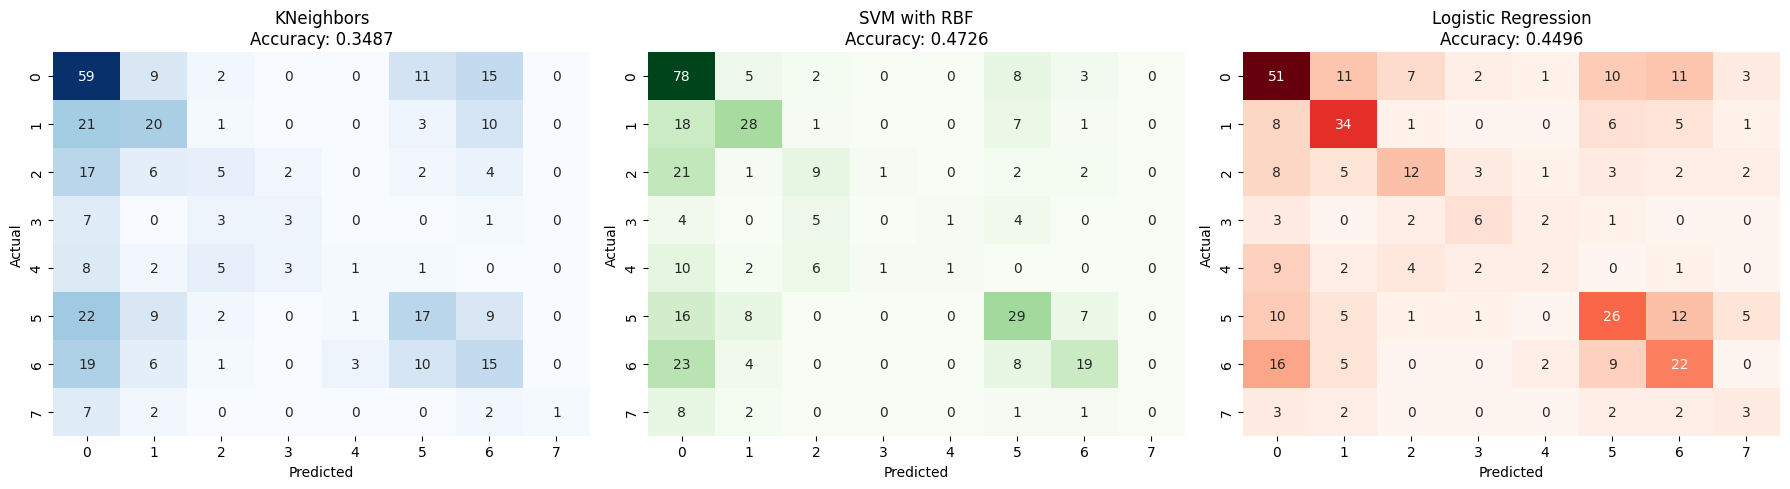

In [ ]:
# Холст для 3 матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Матрица confussion
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'KNeighbors\nAccuracy: {accuracy_knn:.4f}')

# Матрица для SVM с RBF
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Greens',
            cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'SVM with RBF\nAccuracy: {accuracy_svm:.4f}')

# Матрица для Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Reds',
            cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'Logistic Regression\nAccuracy: {accuracy_lr:.4f}')

plt.tight_layout()
plt.show()

## Сравнение по метрика

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Формируем модели
models = {
    'KNeighbors': y_pred_knn,
    'SVM RBF': y_pred_svm,
    'Logistic Regression': y_pred_lr
}

# Создаем таблицу с метриками
results = []
for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Выводим сравнительную таблицу
results_df = pd.DataFrame(results)
print("\nСравнительная таблица метрик:")
print("=" * 60)
print(results_df.round(4))
print("=" * 60)


Сравнительная таблица метрик:
                 Model  Accuracy  Precision  Recall  F1-Score
0           KNeighbors    0.3487     0.3578  0.3487    0.3245
1              SVM RBF    0.4726     0.4540  0.4726    0.4312
2  Logistic Regression    0.4496     0.4412  0.4496    0.4416


## ROC-кривые

In [ ]:
y_prob_knn = model_knn.predict_proba(X_test)
y_prob_svm = model_svm.predict_proba(X_test)
y_prob_lr = model_lr.predict_proba(X_test)

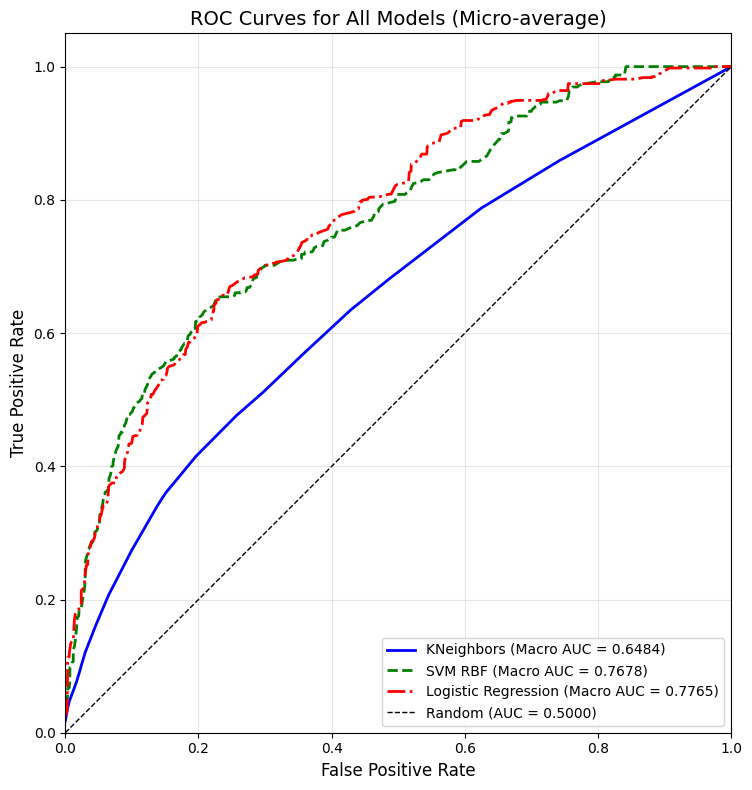

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Подготовка данных для ROC-кривых
y_test_bin = label_binarize(y_test, classes=model_knn.classes_)
n_classes = len(model_knn.classes_)

# Создаем график для ROC-кривых
plt.figure(figsize=(10, 8))

# Модели и их вероятности
models_proba = {
    'KNeighbors': y_prob_knn,
    'SVM RBF': y_prob_svm,
    'Logistic Regression': y_prob_lr
}

# Цвета для разных моделей
colors = ['blue', 'green', 'red']
linestyles = ['-', '--', '-.']

# Вычисляем и рисуем ROC-кривые для каждой модели
for i, (name, y_prob) in enumerate(models_proba.items()):
    # Вычисляем макро-усредненный ROC
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}

    # ROC-кривые для каждого класса
    for j in range(n_classes):
        fpr_dict[j], tpr_dict[j], _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
        roc_auc_dict[j] = auc(fpr_dict[j], tpr_dict[j])

    # Вычисляем макро-усредненную ROC-кривую
    all_fpr = np.unique(np.concatenate([fpr_dict[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[j], tpr_dict[j])
    mean_tpr /= n_classes

    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Рисуем макро-усредненную ROC-кривую
    plt.plot(fpr_macro, tpr_macro,
             color=colors[i],
             linestyle=linestyles[i],
             lw=2,
             label=f'{name} (Macro AUC = {roc_auc_macro:.4f})')

# Рисуем диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5000)')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Models (Micro-average)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Добавляем сетку и оформление
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()